In [1]:
import collections
import io
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential, load_model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7515906842334340317
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3711529245415902308
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11311339693557112905
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18097108169469022374
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [ ]:
lines_eng = io.open(r"/content/drive/My Drive/Machine_translation/en-fr/data/europarl-v7.fr-en.en", encoding = "utf-8").read().split("\n")

In [ ]:
lines_fr=io.open(r"/content/drive/My Drive/Machine_translation/en-fr/data/europarl-v7.fr-en.fr", encoding = "utf-8").read().split("\n")

In [ ]:
for sample_i in range(5):
    print('English sample {}:  {}'.format(sample_i + 1, lines_eng[sample_i]))
    print('French sample {}:  {}\n'.format(sample_i + 1, lines_fr[sample_i]))

English sample 1:  Resumption of the session
French sample 1:  Reprise de la session

English sample 2:  I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
French sample 2:  Je déclare reprise la session du Parlement européen qui avait été interrompue le vendredi 17 décembre dernier et je vous renouvelle tous mes vux en espérant que vous avez passé de bonnes vacances.

English sample 3:  Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.
French sample 3:  Comme vous avez pu le constater, le grand "bogue de l'an 2000" ne s'est pas produit. En revanche, les citoyens d'un certain nombre de nos pays ont été victimes de catastrophes naturelles qui ont vraiment été terribles.

English sample 4:  You

In [ ]:
len(lines_eng)

2007724

In [ ]:
len(lines_fr)

2007724

In [ ]:
english_words_counter = collections.Counter([word for sentence in lines_eng for word in sentence.split()])
hindi_words_counter = collections.Counter([word for sentence in lines_fr for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in lines_eng for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in lines_fr for word in sentence.split()])))
print('{} unique French words.'.format(len(hindi_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*hindi_words_counter.most_common(10)))[0]) + '"')

50263459 English words.
301951 unique English words.
10 Most common words in the English dataset:
"the" "of" "to" "and" "in" "that" "a" "is" "for" "I"

52562231 French words.
395651 unique French words.
10 Most common words in the French dataset:
"de" "la" "et" "le" "à" "les" "des" "que" "en" "du"


In [ ]:
def tokenize(x):
  
    tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))
    
text_sentences = lines_fr[522:525]
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'<OOV>': 1, 'the': 2, 'quick': 3, 'a': 4, 'brown': 5, 'fox': 6, 'jumps': 7, 'over': 8, 'lazy': 9, 'dog': 10, 'by': 11, 'jove': 12, 'my': 13, 'study': 14, 'of': 15, 'lexicography': 16, 'won': 17, 'prize': 18, 'this': 19, 'is': 20, 'short': 21, 'sentence': 22}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [2, 3, 5, 6, 7, 8, 2, 9, 10]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [11, 12, 13, 3, 14, 15, 16, 17, 4, 18]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [19, 20, 4, 21, 22]
{'<OOV>': 1, 'de': 2, 'la': 3, 'le': 4, 'et': 5, 'car': 6, 'dans': 7, 'des': 8, 'pas': 9, "l'emploi": 10, 'que': 11, 'en': 12, 'les': 13, 'fonds': 14, 'leur': 15, 'compétitivité': 16, "s'accroît": 17, 'mais': 18, "l'accroissement": 19, 'richesse': 20, 'ne': 21, 'bénéficie': 22, 'à': 23, 'tout': 24, 'monde': 25, "n'augmente": 26, 'différence': 27, "d'opportunités": 28, "d'emploi": 29, 'persiste': 30, 'certaines':

In [ ]:
import numpy as np
def pad(x, length=None,truncating='post'):
   
    return pad_sequences(x, maxlen=length, padding='post',truncating='post')



test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [15 16 17 18 19  2  3 20 21 22  9 23 24  4 25  6 10 26  9  5  3 27 28 29
 30  7 31 32]
  Output: [15 16 17 18 19  2  3 20 21 22  9 23 24  4 25  6 10 26  9  5  3 27 28 29
 30  7 31 32  0  0  0  0]
Sequence 2 in x
  Input:  [33  4 34 35 36  2  3 37  2 10  5  8 38 39  5 40 41 42 43 44  6 45 46 11
 47  4 48 49  8 50]
  Output: [33  4 34 35 36  2  3 37  2 10  5  8 38 39  5 40 41 42 43 44  6 45 46 11
 47  4 48 49  8 50  0  0]
Sequence 3 in x
  Input:  [ 7  3 51  7 52  8 53 54 12 55  2 56 57  4 58 59  6 60 61 12 62 63 11 64
 13 14 65  5 13 14  2 66]
  Output: [ 7  3 51  7 52  8 53 54 12 55  2 56 57  4 58 59  6 60 61 12 62 63 11 64
 13 14 65  5 13 14  2 66]


In [ ]:
def preprocess(x, y):
  
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x,length=100)
    preprocess_y = pad(preprocess_y,length=100)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(lines_eng[:50000], lines_fr[:50000])
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 100
Max French sentence length: 100
English vocabulary size: 22276
French vocabulary size: 32721


In [ ]:
def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    # Hyperparameters
    learning_rate = 0.003
    
    # Build the layers    
    model = Sequential()
    # Embedding
    model.add(Embedding(english_vocab_size, 128, input_length=input_shape[1],
                         input_shape=input_shape[1:]))
    # Encoder
    model.add(Bidirectional(GRU(128)))
    model.add(RepeatVector(output_sequence_length))
    # Decoder
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(TimeDistributed(Dense(512, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model


print('Final Model Loaded')

Final Model Loaded


In [ ]:
def final_predictions(x, y, x_tk, y_tk):
   
    model = model_final(x.shape,y.shape[1],
                        len(x_tk.word_index)+1,
                        len(y_tk.word_index)+1)
    model.summary()
    model.fit(x, y, batch_size=128, epochs=5, validation_split=0.2)
    model.save('/content/drive/My Drive/Machine_translation/en-fr/bi_gru.h5')
    del model

final_predictions(preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer)

In [ ]:
def final_predictions(x, y, x_tk, y_tk):
    
    model=load_model('/content/drive/My Drive/Machine_translation/en-fr/bi_gru.h5')
    model.summary()
    model.fit(x, y, batch_size=128, epochs=10, validation_split=0.2)

    
    model.save('/content/drive/My Drive/Machine_translation/en-fr/bi_gru.h5')
    del model



final_predictions(preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 128)          2851456   
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 256)               197376    
_________________________________________________________________
repeat_vector_13 (RepeatVect (None, 100, 256)          0         
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 100, 256)          295680    
_________________________________________________________________
time_distributed_25 (TimeDis (None, 100, 512)          131584    
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 512)          0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 100, 32722)      

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 43 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (28.6 MB/s)
debconf: unable to initia

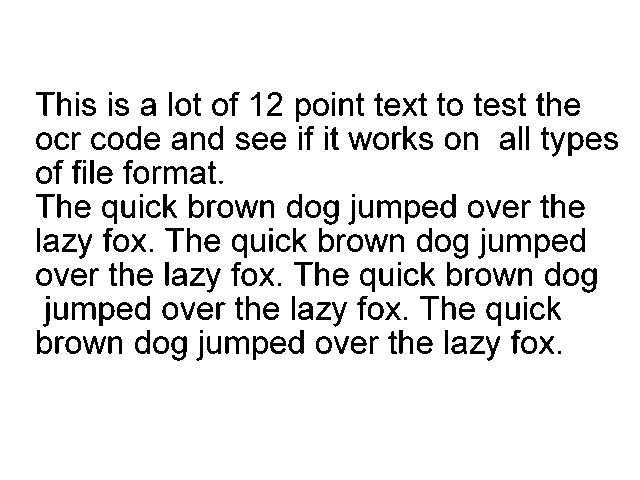

In [ ]:
from IPython.display import Image
pil_img = Image(image_path_in_colab)
display(pil_img)

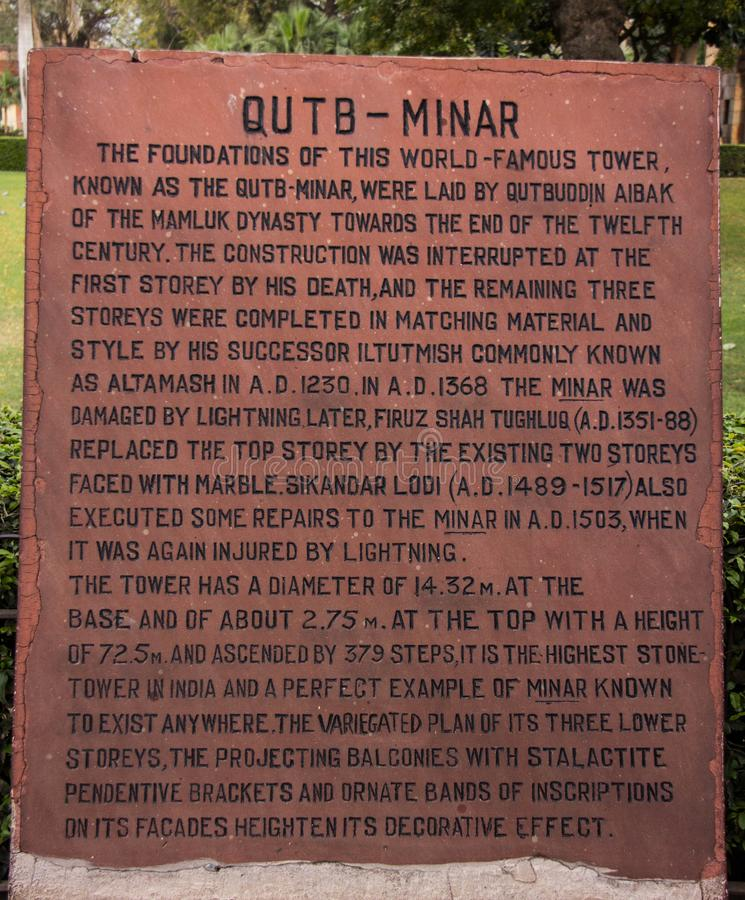

In [ ]:
image_path_in_colab1 = 'drive/My Drive/Machine_translation/en-fr/qutub_test.jpg'
from IPython.display import Image
pil_img = Image(image_path_in_colab1)
display(pil_img)

In [ ]:
import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image

In [ ]:
%ls

drive/  __pycache__/  sample_data/  token_.py


In [ ]:
image_path_in_colab = 'drive/My Drive/Machine_translation/en-fr/test.png'

extractedInformation = pytesseract.image_to_string(Image.open(image_path_in_colab))
text_test = extractedInformation 
print(text_test)

This is a lot of 12 point text to test the
ocr code and see if it works on all types
of file format.

The quick brown dog jumped over the
lazy fox. The quick brown dog jumped
over the lazy fox. The quick brown dog
jumped over the lazy fox. The quick
brown dog jumped over the lazy fox.


In [ ]:
model=load_model('/content/drive/My Drive/Machine_translation/en-fr/bi_gru.h5')

a=[english_tokenizer.word_index[word] for word in text_test.split()]
a=np.array(pad_sequences(a, maxlen=preproc_english_sentences.shape[-1], padding='post'))
print(a)
prediction=model.predict(a,len(a))

y_id_to_word = {value: key for key, value in french_tokenizer.word_index.items()}
y_id_to_word[0] = '<PAD>'
print(y)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[[   11     7     8   969     3   955   119   494     4  2223     2     1
   1612     5   171    49    16  2237    14    34  1898     3  6519  7248
      2  3725 10440 12050 20440   189     2 20308     1     2  3725 10440
  12050 20440   189     2 20308     1     2  3725 10440 12050 20440   189
      2 20308     1     2  3725 10440 12050 20440   189     2 20308     1
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Il s'agit d'un texte de 12 points pour tester la
code ocr et voir s'il fonctionne sur tous les types
du format de fichier.

Le rapide chien brun a sauté par-dessus
renard paresseux. Le chien brun rapide a sauté
sur le renard paresseux. Le chien brun rapide
sauté par-dessus le renard paresseux. Le rapide
chien brun a sauté par-dessus le renard paresseux.


In [ ]:
image_path_in_colab1 = 'drive/My Drive/Machine_translation/en-fr/qutub_test.jpg'

extractedInformation = pytesseract.image_to_string(Image.open(image_path_in_colab1))
text_test = extractedInformation 
print(text_test)

QUTB-MINAR
THE FOUNDATIONS OF THIS WORLD -FAMOUS TOWER, 7
. KNOWN AS THE QUTB-MINAR, WERE LAID BY QUTBUDDIN AIBAK Be
OF THE MAMLUK DYNASTY TOWARDS THE END OF THE TWELFTH i
CENTURY. THE CONSTRUCTION WAS INTERRUPTED AT THE
FIRST STOREY BY HIS DEATH, AND THE REMAINING THREE
STOREYS WERE COMPLETED IN MATCHING MATERIAL AND
STYLE BY HIS SUCCESSOR ILTUTMISH COMMONLY KNOWN
AS ALTAMASH IN A.D.1230.IN A.D.1368 THE MINAR WAS
DAMAGED BY LIGHTNING LATER, FIRUZ SHAH TUGHLUG (A. D.I3SI- -88)
REPLACED THE TOP STOREY BY THE EXISTING TWO STOREYS ©
FACED WITH MARBLE. SIKANDAR LODI (A. B.1489-15 I7ALSO
EXECUTED SOME REPAIRS TO THE MINAR IN A.D.1503, WHEN [-
IT WAS AGAIN INJURED BY LIGHTNING.
THE TOWER HAS A DIAMETER OF 14. 32m. AT THE
BASE AND OF ABOUT 2.75 m. AT THE TOP WITHA HEIGHT
OF 72. 2.5m. AND ASCENDED BY 379. STEPS, IT IS THE: HIGHEST STONE>
TOWER my INDIA AND A PERF ECT EXAMPLE Fs MINAR KNOWN
_TOEXIST ANYWHERE TI HE VARIEGATED. es

oie

re

. eos aa

   

 

ities

STOREYS, THE PROJECTING BALCONI

In [ ]:
model=load_model('/content/drive/My Drive/Machine_translation/en-fr/bi_gru.h5')
a=[english_tokenizer.word_index[word] for word in text_test.split()]
a=np.array(pad_sequences(a, maxlen=preproc_english_sentences.shape[-1], padding='post'))
print(a)
prediction=model.predict(a,len(a))

y_id_to_word = {value: key for key, value in french_tokenizer.word_index.items()}
y_id_to_word[0] = '<PAD>'
print(y)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[[    1     1     8  2395     1   870     1  5588    91 11844     4     2
      1     6     8  8310     1    90    16    53   237  5211    24     1
      2 11674    26     8     1     3  1127     1    30     2  1506     5
      3    69   481  3584   660    30     2  1870     1 12816     3  7231
    481  7352     5     1    24     1  1228    16     7     2  1735  7156
  11674    66  3248     5     8     1     1   193     1     1  1029     1
   3243     1   200     1  5019     1  1290     1     1     1     1     2
      1     1     1     1 17877     5     1     1     1 14154     1     1
      1     1     1  8730]]
QUTB-MINAR
LES FONDEMENTS DE CETTE TOUR MONDIALE -FAMOUS, 7
. CONNU COMME QUTB-MINAR, A ÉTÉ MIS EN PLACE PAR QUTBUDDIN AIBAK Be
DE LA DYNASTIE MAMLOUQUE VERS LA FIN DU DOUZIÈME i
SIÈCLE. LA CONSTRUCTION A ETE INTERROMPUE AU
PREMIER ÉTAGE PAR SA MORT ET LES TROIS RESTANTS
LES ÉTAGES ONT ÉTÉ COMPLÉTÉS EN MATÉRIAU CORRESPONDANT ET
LE STYLE DE SON SUCCESSEUR ILTUTMISH CONNU
COMME A